# Comparison With IES

IES has the TM52 calculation built-in. 

Our script was developed before the IES version was available, and continues to have the following benefits: 
- test easily over multiple air speeds
- test over different reporting intervals (this is a requirement for Part O modelling)
- we can output the data (and graphs etc.) in a way that can be immediately useful when writing reports
- apply CIBSE's guidance to use additional cooling with respect to the air speeds

To benchmark the analysis procedure of our script, we tested with this model:

J:\J4321\Apps\IES-dev\adaptive_comfort\tests\testmodels\TestJob1

As mentioned above, IES's version does not account for additional cooling and, as stated in the guidance, additional cooling is ignored if the air speed is less than or equal to 0.1 metres per second. Therefore, we have produced a report using IES's script where elevated air speed is set to 0.1 metres per second. 

We then obtained the results produced from our script where elevated air speed is 0.1 metres per second so we could compare the two reports. The criterion results from both reports should be the same.

## Known Issues

We have discovered an inconsistency between the dry-bulb temperature obtained from the Python API and the dry-bulb temperature obtained from VistaPro. 

Upon comparison, the data is ever so slightly different which has led to the running mean temperature, max acceptable temperature, and the operative temperature slightly deviating from the IES output. You can see visualisations of this further down this page.

We have reported this issue to IES and are awaiting a response. Link to the forum post here: https://forums.iesve.com/viewtopic.php?t=76699&sid=590d8b2e529d06c0012423b15863e09f

Below are plots showing the difference between the dry-bulb temperature obtained from the IES API and VistaPro.

Whilst this is hugely frustrating, the differences are minor and do not impact the outcome of the analysis in a meaningful way.

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cwd = pathlib.Path().cwd()

In [3]:
# Load dry-bulb from API and VistaPro
arr_from_api = np.load(cwd / "tests" / "arr_dry_bulb_temp.npy")
df = pd.read_csv(cwd / "tests" / "dry_bulb_temperature_from_vista.txt", delimiter="\t", encoding='latin1', header=2)
arr_from_vista = np.array(df.iloc[:, 2])

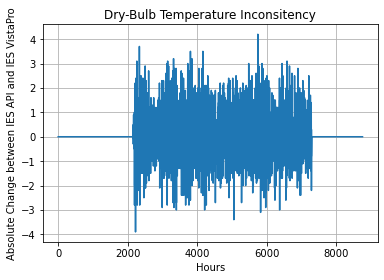

In [4]:
abs_change = arr_from_api[:-1] - arr_from_vista[1:]
plt.plot(range(len(abs_change)), abs_change)
plt.xlabel('Hours')
plt.ylabel('Absolute Change between IES API and IES VistaPro')
plt.title('Dry-Bulb Temperature Inconsistency')
plt.grid(True)
plt.show()


The above plot shows us the absolute difference between the dry-bulb temperatures: one obtained from the IES Python API; the other from VistaPro. We see that up to around the 2000 hours mark, the values are identical (the difference is 0). Then suddenly there is a fluctuation in the data following this. It then returns back to being identical after around 7000 hours.

From looking at the data explicitly, from around 2000 hours, the hours start going 1 hour out of sync, i.e. the temperature given from VistaPro for the 3000th hour is the temperature given at the 2999th hour from the Python API. You could say that the temperatures from each source become 1 hour out-of-phase with one another.

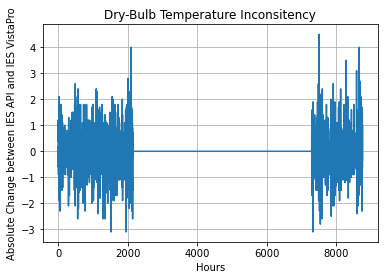

In [5]:
abs_change = arr_from_api[:-2] - arr_from_vista[2:]
plt.plot(range(len(abs_change)), abs_change)
plt.xlabel('Hours')
plt.ylabel('Absolute Change between IES API and IES VistaPro')
plt.title('Dry-Bulb Temperature Inconsistency')
plt.grid(True)
plt.show()

Now the plot above shows what happens if I account for this 1 hour out-of-phase recordings. The values which were incorrect before are now identical, however, the values that were identical in the previous plot, are now inconsistent.

We are not sure what is causing this issue, however, we hope IES will provide us with a response as to why this is the case. Then we can work towards a solution to have this resolved as soon as possible.

## Criteria Failing

Following that, we should see whether the issue above affects our report. Let's see whether the correct criteria are failing.

Firstly, let's see whether the same rooms fail when using IES compared to our (Max Fordham) results. 

In [10]:
FPTH_TEST_ALL_CRITERIA = cwd / "tests" / "test_all_criteria.xlsx"
df = pd.read_excel(FPTH_TEST_ALL_CRITERIA, sheet_name=None)

In [11]:
del df["Criteria Failing, Air Speed 0.1"]["index"]
df["Criteria Failing, Air Speed 0.1"].fillna('')

,Room Name,IES Results,MF Results,IES v MF
0,A_01_XX_XX_ApartmentSW,2,2,True
1,A_01_XX_XX_ApartmentS1,1 & 2,1 & 2,True
2,A_01_XX_XX_ApartmentS2,1 & 2,1 & 2,True
3,A_01_XX_XX_ApartmentN1,,,True
4,A_01_XX_XX_ApartmentNW,,,True
5,A_01_XX_XX_ApartmentNE,,,True
6,A_01_XX_XX_ApartmentN2,,,True
7,A_02_XX_XX_ApartmentSW,1 & 2,1 & 2,True
8,A_02_XX_XX_ApartmentS1,1 & 2,1 & 2,True
9,A_02_XX_XX_ApartmentSE,1 & 2,1 & 2,True


## Criterion 1: IES v MF
We will look at the absolute change and relative change between the IES report and the Max Fordham report. We want to be absolutely sure that our results produce an almost identical output within a very small margin of error.

In [12]:
del df["Criterion 1, Air Speed 0.1"]["index"]  # Remove index column
df["Criterion 1, Air Speed 0.1"].fillna('')  # Show data frame

,Room Name,IES Results,MF Results,Criterion 1 Absolute Change,Criterion 1 Relative Change (%)
0,A_01_XX_XX_ApartmentSW,2.5,2.5,0.0,0.0
1,A_01_XX_XX_ApartmentS1,7.8,7.9,0.1,1.282051
2,A_01_XX_XX_ApartmentS2,8.1,8.0,-0.1,-1.234568
3,A_01_XX_XX_ApartmentN1,0.0,0.0,0.0,
4,A_01_XX_XX_ApartmentNW,0.0,0.0,0.0,
5,A_01_XX_XX_ApartmentNE,0.0,0.0,0.0,
6,A_01_XX_XX_ApartmentN2,0.0,0.0,0.0,
7,A_02_XX_XX_ApartmentSW,10.6,10.6,0.0,0.0
8,A_02_XX_XX_ApartmentS1,26.0,26.0,0.0,0.0
9,A_02_XX_XX_ApartmentSE,11.6,11.6,0.0,0.0


```{note}
Empty relative change cells are due to division by 0.
```

## Criterion 2: IES v MF

In [8]:
del df["Criterion 2, Air Speed 0.1"]["index"]  # Remove index column
df["Criterion 2, Air Speed 0.1"].fillna('')   # Show data frame

,Room Name,IES Results,MF Results,Criterion 2 Absolute Change,Criterion 2 Relative Change (%)
0,A_01_XX_XX_ApartmentSW,11,11,0,0.0
1,A_01_XX_XX_ApartmentS1,14,14,0,0.0
2,A_01_XX_XX_ApartmentS2,15,15,0,0.0
3,A_01_XX_XX_ApartmentN1,0,0,0,NaN
4,A_01_XX_XX_ApartmentNW,0,0,0,NaN
5,A_01_XX_XX_ApartmentNE,0,0,0,NaN
6,A_01_XX_XX_ApartmentN2,0,0,0,NaN
7,A_02_XX_XX_ApartmentSW,25,26,1,4.0
8,A_02_XX_XX_ApartmentS1,27,27,0,0.0
9,A_02_XX_XX_ApartmentSE,31,31,0,0.0


## Criterion 3: IES v MF

In [9]:
del df["Criterion 3, Air Speed 0.1"]["index"]  # Remove index column
df["Criterion 3, Air Speed 0.1"].fillna('')   # Show data frame

,Room Name,IES Results,MF Results,Criterion 3 Absolute Change,Criterion 3 Relative Change (%)
0,A_01_XX_XX_ApartmentSW,2,2,0,0.0
1,A_01_XX_XX_ApartmentS1,2,2,0,0.0
2,A_01_XX_XX_ApartmentS2,2,2,0,0.0
3,A_01_XX_XX_ApartmentN1,0,0,0,NaN
4,A_01_XX_XX_ApartmentNW,0,0,0,NaN
5,A_01_XX_XX_ApartmentNE,0,0,0,NaN
6,A_01_XX_XX_ApartmentN2,0,0,0,NaN
7,A_02_XX_XX_ApartmentSW,3,3,0,0.0
8,A_02_XX_XX_ApartmentS1,3,3,0,0.0
9,A_02_XX_XX_ApartmentSE,3,3,0,0.0


## Running Mean Temperature

In [10]:
FPTH_TEST_ALL_CRITERIA = cwd / "tests" / "test_running_mean_temp.xlsx"
df = pd.read_excel(FPTH_TEST_ALL_CRITERIA, sheet_name=None)
del df["Running Mean Temperature"]["index"]

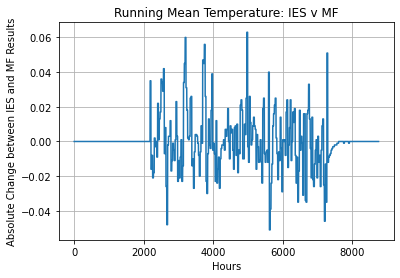

In [11]:
plt.plot(df["Running Mean Temperature"].index, df["Running Mean Temperature"].loc[:, "Absolute Change"])
plt.xlabel('Hours')
plt.ylabel('Absolute Change between IES and MF Results')
plt.title('Running Mean Temperature: IES v MF')
plt.grid(True)
plt.show()

## Max Acceptable Temperature

In [12]:
FPTH_TEST_ALL_CRITERIA = cwd / "tests" / "test_max_acceptable_temp.xlsx"
df = pd.read_excel(FPTH_TEST_ALL_CRITERIA, sheet_name=None)
del df["Max Acceptable Temperature"]["index"]

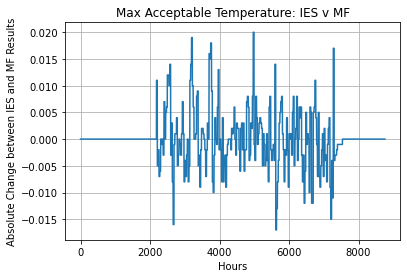

In [13]:
plt.plot(df["Max Acceptable Temperature"].index, df["Max Acceptable Temperature"].loc[:, "Absolute Change"])
plt.xlabel('Hours')
plt.ylabel('Absolute Change between IES and MF Results')
plt.title('Max Acceptable Temperature: IES v MF')
plt.grid(True)
plt.show()

## Operative Temperature

For $v = 0.1ms^{-1}$ where $v$ is the elevated air speed.
We will look at only one room : A_01_XX_XX_ApartmentSW

In [16]:
FPTH_TEST_ALL_CRITERIA = cwd / "tests" / "test_operative_temp.xlsx"
df = pd.read_excel(FPTH_TEST_ALL_CRITERIA, sheet_name=None, usecols="A:E", header=1)
del df["Operative Temp, Air Speed 0.1"]["Unnamed: 0"]
df["Operative Temp, Air Speed 0.1"] = df["Operative Temp, Air Speed 0.1"].drop([0])
df["Operative Temp, Air Speed 0.1"] = df["Operative Temp, Air Speed 0.1"].reset_index(drop=True)

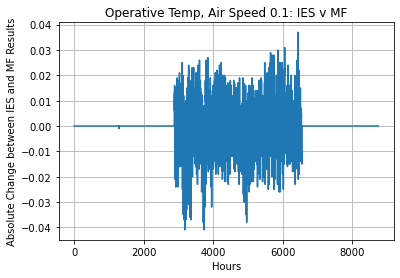

In [15]:
plt.plot(df["Operative Temp, Air Speed 0.1"].index, df["Operative Temp, Air Speed 0.1"].loc[:, "Absolute Change"])
plt.xlabel('Hours')
plt.ylabel('Absolute Change between IES and MF Results')
plt.title('Operative Temp, Air Speed 0.1: IES v MF')
plt.grid(True)
plt.show()